# Should We Play Tennis?

In [2]:
import pandas as pd

data_file = "Tennis.csv"
data = pd.read_csv(data_file)
(nrows, ncols) = data.shape

In [ ]:
# Tools for viewing the data
#print(data.info())          # gives the structure of the data (rows/cols)
#print(data.head())          # shows the top five data entries
#print(data.describe())      # gives the statistics on the data in the DF

### Convert string features to integers

In [3]:
colnames = list(data.columns.values)
string_encoding = {}
data_encoded = data.copy()
for i in range(ncols):
    levels = list(set(data.iloc[:, i]))
    num_levels = len(levels)
    string_encoding_i = dict(zip(levels, range(num_levels)))
    string_encoding[colnames[i]] = string_encoding_i
    for j in range(nrows):
        data_encoded.iloc[j, i] = string_encoding_i[data.iloc[j, i]]

print(string_encoding)
print(data_encoded.head())

{'outlook': {'overcast': 0, 'sunny': 1, 'rain': 2}, 'temp': {'mild': 0, 'hot': 1, 'cool': 2}, 'humidity': {'high': 0, 'normal': 1}, 'windy': {'weak': 0, 'strong': 1}, 'play': {'yes': 0, 'no': 1}}
   outlook  temp  humidity  windy  play
0        1     1         0      1     1
1        1     1         0      0     1
2        0     1         0      0     0
3        2     0         0      0     0
4        2     2         1      0     0


### One Hot Encoding Categorial Variables

In [5]:
from sklearn import preprocessing
enc = preprocessing.OneHotEncoder()
enc.fit(data_encoded.iloc[:,0:4])
data_onehotencoded = enc.transform(data_encoded.iloc[:,0:4])
feature_names = ["outlook_rainy", "outlook_overcast", "outlook_sunny", \
                 "temp_mild", "temp_hot", "temp_cool", \
                 "humidity_normal", "humidity_high", \
                 "windy_false", "windy_true"]

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


### Assign the X (feature) and Y (class) Arrays and Split into Train and Test Data

In [7]:
from sklearn import tree
import numpy as np
from sklearn.model_selection import train_test_split 

# Ensure the decision tree is deterministic
np.random.seed(101)

X = data_onehotencoded.toarray()
Y = data_encoded.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 99)
print(y_test)

0     1
12    0
Name: play, dtype: int64


### Generate and Evaluate the Model

In [8]:
# Generate the Classification model
from sklearn.tree import DecisionTreeClassifier
dec_tree_ent = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model = dec_tree_ent.fit(X_train,y_train)

# Validate the model
y_predict_ent = model.predict(X_test)

In [9]:
# Generate the accuracy score
from sklearn.metrics import accuracy_score

#def measure_performance(X_train, y_train)
acc_ent = accuracy_score(y_test, y_predict_ent) * 100
print("Accuracy is : {}%".format(acc_ent))

Accuracy is : 100.0%


### Create a Confusion Matrix

In [10]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(
    confusion_matrix(y_test, y_predict_ent),
    columns=['Predicted Don\'t Play', 'Predicted Play'],
    index=['True Don\'t play', 'True Play']
)

,Predicted Don't Play,Predicted Play
True Don't play,1,0
True Play,0,1


### Test Other Split Criterion

In [11]:
# Use Gini impurity (default) instead of Information Gain (entropy)
dec_tree_gini = DecisionTreeClassifier().fit(X_train,y_train)  
# Validate the model
y_predict_gini = dec_tree_gini.predict(X_test)

# Generate the accuracy score
acc_gini = accuracy_score(y_test, y_predict_gini) * 100
print("Accuracy is : {}%".format(acc_gini))

Accuracy is : 100.0%


### Visualize the Decision Tree

In [13]:
from sklearn import tree

# NOTE: Must install the graphviz executables for this to work and possibly update your computer's PATH
#       https://graphviz.gitlab.io/_pages/Download/Download_windows.html 
# When using Anaconda run this at the command prompt: 'conda install -c anaconda graphviz' 

#create a visualization of the tree -- must install graphviz and pydot2 packages for this to work
dotfile1 = open("tennis_ent.dot", 'w')
tree.export_graphviz(dec_tree_ent, out_file = dotfile1, filled=True, rounded=True, feature_names = feature_names)
dotfile1.close()

dotfile2 = open("tennis_gini.dot", 'w')
tree.export_graphviz(dec_tree_gini, out_file = dotfile2, filled=True, rounded=True, feature_names = feature_names)
dotfile2.close()

# Convert the dot file to a png
from subprocess import check_call
check_call(['dot','-Tpng','tennis_ent.dot','-o','tennis_ent.png'])
check_call(['dot','-Tpng','tennis_gini.dot','-o','tennis_gini.png'])

0

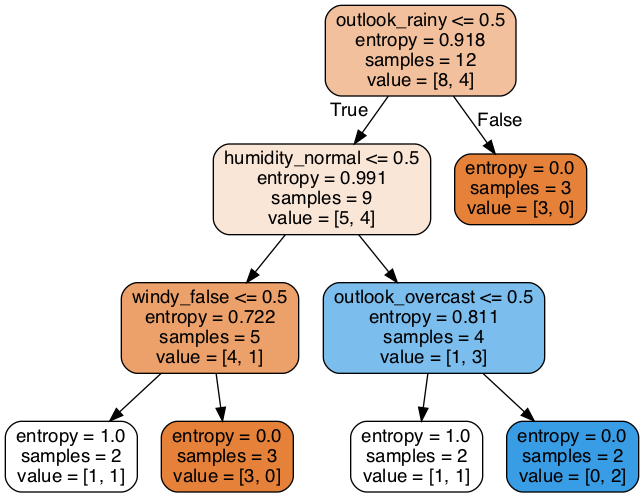

In [15]:
from IPython.display import Image
Image(filename='tennis_ent.png', width=500, height=500)

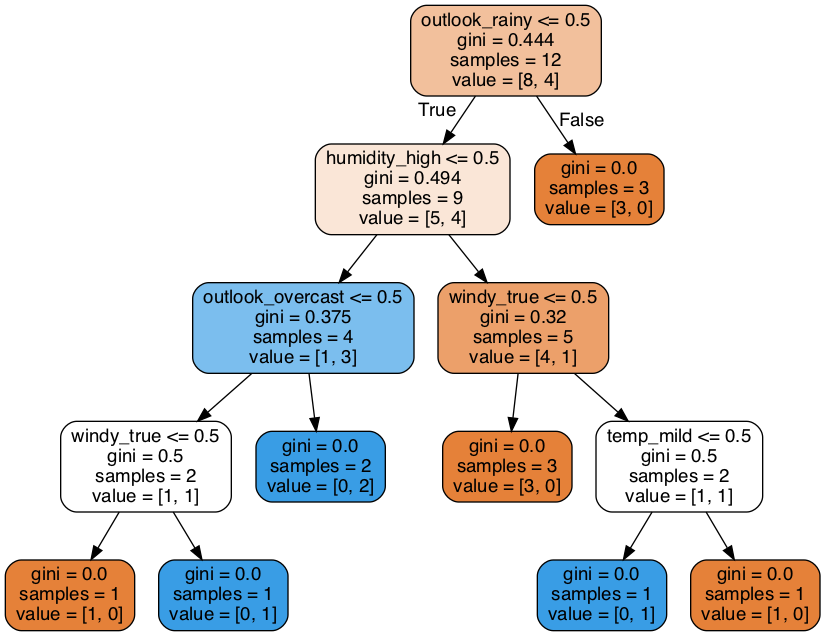

In [16]:
from IPython.display import Image
Image(filename='tennis_gini.png', width=500, height=500)

## What if I didn't have a "test set"? 
What would the tree look like if rather than generating an accuracy score for evaluation purposes, I just let it build the tree and see what happens. 

What do you think might occur?

In this case I'm just loading up the raw data, X and Y.

In [ ]:
dec_tree_ent_new = DecisionTreeClassifier(criterion='entropy').fit(X,Y)  
dotfile_new = open("tennis_ent_new.dot", 'w')
tree.export_graphviz(dec_tree_ent_new, out_file = dotfile_new, filled=True, rounded=True, feature_names = feature_names)
dotfile_new.close()
os.system("dot -Tpng tennis_ent_new.dot -o tennis_ent_new.png")
from IPython.display import Image
Image(filename='tennis_ent_new.png', width=750, height=750)

### Add a new 'noisy' row and test for overfitting

Now I'm going to create a new row to testset without retraining the existing models to see how they do. 

In [ ]:
print(X_test)
print(y_test)
numY = len(y_test)
print(numY)

In [ ]:
# Add Outlook=Sunny, temp=Hot, humidity=Normal, Windy=Strong, Play=no
new_X = np.array([1., 0., 0., 0., 0., 1., 1., 0., 0., 1.])
new_y = 1

X_test = np.vstack([X_test, new_X])
y_test = np.hstack([y_test, new_y])

In [ ]:
#print(X_test)
#print(y_test)
#numY = len(y_test)
#print(numY)

In [ ]:
## Put the noisy test through the two models
y_predict_ent2 = dec_tree_ent.predict(X_test)
y_predict_gini2 = dec_tree_gini.predict(X_test)

# Generate the accuracy score
acc_ent2 = accuracy_score(y_test, y_predict_ent2) * 100
print("Accuracy is : {}%".format(acc_ent2))

# Generate the accuracy score
acc_gini2 = accuracy_score(y_test, y_predict_gini2) * 100
print("Accuracy is : {}%".format(acc_gini2))

In [ ]:
pd.DataFrame(
    confusion_matrix(y_test, y_predict_ent2),
    columns=['Predicted Don\'t Play', 'Predicted Play'],
    index=['True Don\'t play', 'True Play']
)

In [ ]:
pd.DataFrame(
    confusion_matrix(y_test, y_predict_gini2),
    columns=['Predicted Don\'t Play', 'Predicted Play'],
    index=['True Don\'t play', 'True Play']
)